In [6]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

# Data Preparation

In [2]:
data = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv')

In [3]:
df = data

In [4]:
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [5]:
df.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [7]:
df.dtypes

lead_source                  object
industry                     object
number_of_courses_viewed      int64
annual_income               float64
employment_status            object
location                     object
interaction_count             int64
lead_score                  float64
converted                     int64
dtype: object

In [8]:
numerical =['number_of_courses_viewed', 'annual_income','interaction_count', 'lead_score', 'converted']

In [9]:
categorical = ['lead_source', 'industry','employment_status', 'location']

In [10]:
df[numerical] = df[numerical].fillna(0.0)

In [11]:
df[categorical] = df[categorical].fillna('NA')

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [14]:
len(df_train), len(df_val), len(df_test)

(876, 293, 293)

In [15]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [16]:
y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values

del df_train['converted']
del df_val['converted']
del df_test['converted']

# ROC AUC Importance

In [33]:
from sklearn.metrics import roc_auc_score
numerical_columns = ['number_of_courses_viewed', 'annual_income','interaction_count', 'lead_score']
auc_scores = []
for col in numerical_columns:
    X_col = df_train[col].values.reshape(-1, 1)
    auc = roc_auc_score(y_train.ravel(), X_col).round(3)
    if auc < 0.5:
        X_col = -X_col
        auc = roc_auc_score(y_train.ravel(), X_col).round(3)
    auc_scores.append(auc)

auc_scores_df = pd.DataFrame(auc_scores, index=numerical_columns, columns=['AUC'])
auc_scores_df.sort_values(ascending=False, by='AUC', inplace=True)
auc_scores_df



,AUC
number_of_courses_viewed,0.764
interaction_count,0.738
lead_score,0.614
annual_income,0.552


# Training the Model

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer

In [35]:
def data_transformation(df_tr, df_val):
    df_tr_dicts = df_tr.to_dict(orient='records')
    df_val_dicts = df_val.to_dict(orient='records')
    dv = DictVectorizer(sparse=False)
    df_onehot_tr = dv.fit_transform(df_tr_dicts)
    df_onehot_val = dv.transform(df_val_dicts)
    return df_onehot_tr, df_onehot_val

In [36]:
df_onehot_train, df_onehot_val = data_transformation(df_train, df_val)

In [37]:
lr = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
lr.fit(df_onehot_train, y_train)
y_pred = lr.predict_proba(df_onehot_val)[:, 1]
roc_auc_score(y_val, y_pred).round(3)

0.817

# Precision and Recall

In [60]:
thresholds = np.linspace(0.0, 0.99, 100)
scores = []
for t in thresholds:
    tp = (y_pred >= t) & (y_val == 1)
    fp = (y_pred >= t) & (y_val == 0)
    tn = (y_pred < t) & (y_val == 0)
    fn = (y_pred < t) & (y_val == 1)
    
    p = tp.sum() / (tp.sum() + fp.sum())
    r = tp.sum() / (tp.sum() + fn.sum())
    scores.append((t, p, r, p-r))

p_r_df = pd.DataFrame(scores, columns=['threshold', 'precision', 'recall', 'p_minus_r'])

C:\Users\Elitebook\AppData\Local\Temp\ipykernel_19424\2893929433.py:9: RuntimeWarning: invalid value encountered in scalar divide
  p = tp.sum() / (tp.sum() + fp.sum())


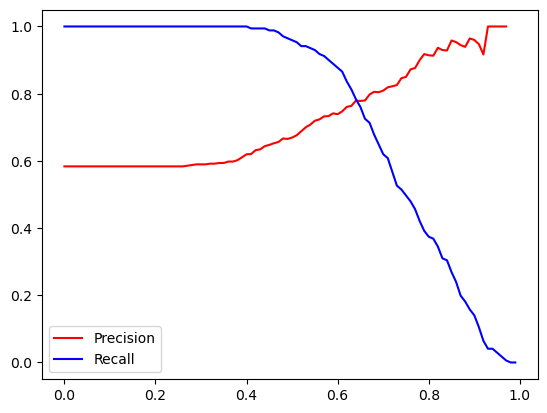

In [61]:
fig, ax = plt.subplots()
ax.plot(thresholds, p_r_df.precision, color='red', label='Precision')
ax.plot(thresholds, p_r_df.recall, color='blue', label='Recall')
ax.legend();

In [62]:
p_r_df['minus_abs_p_minus_r'] = p_r_df.p_minus_r.apply(lambda x: -abs(x))
p_r_df[['threshold', 'minus_abs_p_minus_r']].nlargest(5, 'minus_abs_p_minus_r')

,threshold,minus_abs_p_minus_r
64,0.64,-0.004556
65,0.65,-0.018209
63,0.63,-0.049129
66,0.66,-0.054728
62,0.62,-0.075619


# F1 Score

In [63]:
thresholds = np.linspace(0.0, 0.99, 100)
f1_scores = []
for t in thresholds:
    tp = (y_pred >= t) & (y_val == 1)
    fp = (y_pred >= t) & (y_val == 0)
    tn = (y_pred < t) & (y_val == 0)
    fn = (y_pred < t) & (y_val == 1)
    
    p = tp.sum() / (tp.sum() + fp.sum())
    r = tp.sum() / (tp.sum() + fn.sum())
    f1 = 2*p*r/(p+r)
    f1_scores.append((t, f1))

f1_df = pd.DataFrame(f1_scores, columns=['threshold', 'f-score'])

C:\Users\Elitebook\AppData\Local\Temp\ipykernel_19424\3950889907.py:9: RuntimeWarning: invalid value encountered in scalar divide
  p = tp.sum() / (tp.sum() + fp.sum())


In [64]:
f1_df.nlargest(5, 'f-score')

,threshold,f-score
57,0.57,0.812500
55,0.55,0.811224
56,0.56,0.809278
59,0.59,0.808511
58,0.58,0.808399


# 5-Fold CV

In [66]:
from sklearn.model_selection import KFold

In [67]:
def train(df_train, y_train, C=1.0):
    dicts = df_train.to_dict(orient='records')
    dv = DictVectorizer(sparse=False)
    df_train = dv.fit_transform(dicts)
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(df_train, y_train)
    return dv, model

In [68]:
def predict(df_val, dv, model):
    dicts = df_val.to_dict(orient='records')
    df = dv.transform(dicts)
    y_pred = model.predict_proba(df)[:, 1]
    return y_pred

In [87]:
n_splits = 5
C = 1.0  

kf = KFold(n_splits=n_splits, shuffle=True, random_state=1)
scores = []

for train_idx, val_idx in kf.split(df_train):
    df_train_fold = df_train.iloc[train_idx]
    df_val_fold = df_train.iloc[val_idx]
    y_train_fold = y_train[train_idx]
    y_val_fold = y_train[val_idx]

    dv, model = train(df_train_fold, y_train_fold, C)
    y_pred = predict(df_val_fold, dv, model)

    auc = roc_auc_score(y_val_fold, y_pred)
    scores.append(auc)

print(f'C: {C:<6} AUC: {np.std(scores):.3f}')


C: 1.0    AUC: 0.032


# Hyperparameter Tuning

In [86]:
n_splits = 5

for C in [0.000001, 0.001, 1]:
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=1)
    scores = []

    for train_idx, val_idx in kf.split(df_train):
        df_train_fold = df_train.iloc[train_idx]
        df_val_fold = df_train.iloc[val_idx]
        y_train_fold = y_train[train_idx]
        y_val_fold = y_train[val_idx]

        dv, model = train(df_train_fold, y_train_fold, C)
        y_pred = predict(df_val_fold, dv, model)

        auc = roc_auc_score(y_val_fold, y_pred)
        scores.append(auc)
    
    print(f'C: {C:<10} AUC: {np.mean(scores):.3f} +/- {np.std(scores):.3f}')


C: 1e-06      AUC: 0.510 +/- 0.032
C: 0.001      AUC: 0.510 +/- 0.032
C: 1          AUC: 0.510 +/- 0.032
